In [1202]:
import numpy as np
import pickle
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import community
import difflib

In [1203]:
# load in data
with open('/Users/rohanramesh/Documents/SportsData/NBA/AllYearlyData_2008_2018.pickle', 'rb') as handle:
    df_all_stats = pickle.load(handle)

with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyTeamData.pickle', 'rb') as handle:
    df_teams = pickle.load(handle)
    
years_to_use = range(2008,2019)

In [1204]:
# have to redefined team names in df to match the players version
for curr_year in years_to_use[1:]:
    # need to adjust for difference betwen Tm labels
    # these are all teams according to the player data
    list_of_teams_mult = df_all_stats[str(curr_year)]['Tm']
    all_teams = list_of_teams_mult.drop_duplicates().tolist()

    # teams according to team df
    teams_according_to_team_df = df_teams[str(curr_year)]['Tm'].tolist()
    # remove everything after city name but before team acronym
    new_team_ = [curr_team[curr_team.rfind(" ")+1:] for curr_team in teams_according_to_team_df]
    # bc of team transferring from New Jersey to Brooklyn and websited not being up to date add
    if curr_year == 2012:
        new_team_ = [w.replace('BKN', 'NJN') for w in new_team_]
    
    # now iterate through new team and find best match from all_teams
    new_team_aligned = []
    for curr_team in new_team_:    
        new_team_aligned.append(difflib.get_close_matches(curr_team,all_teams, n=1)[0])

    df_teams[str(curr_year)]['Tm'] = new_team_aligned


In [1427]:
# functions to build the Graphs
def build_graphs_each_team(df_all_stats,curr_year,curr_team):
    """ for any team on any particular year build a graph where all of the nodes are individual players 
    and the edges connecting players is a ratio between player A's relative assist rate and player B's
    relative scoring total. Each edge basically describes that pairs contribution to the teams scoring 
    at the level of assists and scoring
    ratio for edges = (100 * AST person A / AST total) * (100 * PS/G person B / PS/G total)"""
    idx = (df_all_stats[curr_year]['Tm'] == curr_team) & (df_all_stats[curr_year]['MP_adv'] > 200)
    Team_df = df_all_stats[curr_year][['Player','AST','PS/G','Pos','MP']][idx]
    # can't keep everyone bc some rosters bigger than others so will mess up stats - taking the top 8 players 
    Team_df = Team_df.sort_values(['MP'], ascending=False)
    Team_df = Team_df.iloc[0:8]
    curr_team_ast_pts = Team_df[['AST', 'PS/G']].values
    summed_ast_pts = curr_team_ast_pts.sum(axis=0)
    # lets make a matrix of all pairwise comparisons
    all_pairwise_edges = np.ndarray(shape= (np.shape(curr_team_ast_pts)[0],np.shape(curr_team_ast_pts)[0]))
    # build the ratio for edges = (100 * AST for a person / AST total) * (100 * PTS for a person / PTS total)
    for i in range(0,np.shape(curr_team_ast_pts)[0]):
        for j in range(0,np.shape(curr_team_ast_pts)[0]):
#             all_pairwise_edges[i,j] = (100 * curr_team_ast_pts[i][0]/summed_ast_pts[0]) * (100 * curr_team_ast_pts[j][1]/summed_ast_pts[1])
            all_pairwise_edges[i,j] = (curr_team_ast_pts[i][0]) * (curr_team_ast_pts[j][1])


    # for the nodes lets use player names
    pnames = Team_df['Player'].tolist()
    curr_positions = Team_df['Pos'].tolist()
    minutes_played = Team_df['MP'].tolist()
    ast_given = Team_df['AST'].tolist()
    unique_pos = list(set(curr_positions))
    cm = plt.get_cmap('inferno',5) # 5 bc of the 5 positions
    nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos)) if i == unique_pos[j]]
    node_size_use = Team_df['PS/G']
    node_size_use = node_size_use.as_matrix()
    G = nx.DiGraph()
    G.add_nodes_from(pnames)
    # to save the PS/G for node size later
    points_per_game = {}
    pos_ = {}
    mp_ = {}
    ast_ = {}
    for i in range(0,len(pnames)):
        points_per_game[pnames[i]] = node_size_use[i]
        pos_[pnames[i]] = curr_positions[i]
        mp_[pnames[i]] = minutes_played[i]
        ast_[pnames[i]] = ast_given[i]
    nx.set_node_attributes(G, points_per_game, 'ppg')
    nx.set_node_attributes(G, pos_, 'pos')
    nx.set_node_attributes(G, mp_, 'mp')
    nx.set_node_attributes(G, ast_, 'ast')
    labels_use = {}
    outward_vs_inward_direction = []
    for i in range(0,np.shape(curr_team_ast_pts)[0]):
        labels_use[pnames[i]] = pnames[i]
#         for j in range(0,np.shape(curr_team_ast_pts)[0]):
#                 G.add_edge(pnames[i],pnames[j], weight= all_pairwise_edges[i,j])
#                 G.add_edge(pnames[j],pnames[i], weight= all_pairwise_edges[j,i])
        for j in range(i+1,np.shape(curr_team_ast_pts)[0]):
            if (all_pairwise_edges[i,j] > all_pairwise_edges[j,i]) & (all_pairwise_edges[i,j] > 5):
                G.add_edge(pnames[i],pnames[j], weight= all_pairwise_edges[i,j])
                outward_vs_inward_direction.append('k')
            elif (all_pairwise_edges[j,i] > all_pairwise_edges[i,j]) & (all_pairwise_edges[j,i] > 5):
                G.add_edge(pnames[j],pnames[i], weight= all_pairwise_edges[j,i])
                outward_vs_inward_direction.append('k')
    return G

def visualize_graph_for_team_year(G):
    """ visualize the graph """
    pos = nx.kamada_kawai_layout(G)
#     pos=nx.spring_layout(G, iterations=500)
    # pos=nx.circular_layout(G)
    cm = plt.get_cmap('inferno_r',7) # 6 bc of the 5 positions and no black
    unique_pos = ['PG','SG','SF','PF','C']
    curr_positions = nx.get_node_attributes(G,'pos')
    nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos)) 
                  if curr_positions[i] == unique_pos[j]]
    edge_labels=dict([((u,v,),round(d['weight']))
                     for u,v,d in G.edges(data=True)])
    # for the node size
    node_size_use = nx.get_node_attributes(G,'ppg')
    node_array = [node_size_use[i]*25 for i in list(node_size_use)]
    labels_use = {}
    for i in G.nodes():
        labels_use[i] = i
    # print(edge_labels)
    edgewidth = [d['weight']/25 for (u, v, d) in G.edges(data=True)]
    # # we can now added edge thickness and edge color
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_array, node_color=nodecolors,alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.15, arrowstyle= 'simple', arrowsize=5, arrows=False,
                           edge_cmap=plt.cm.Greys)
    nx.draw_networkx_labels(G, pos, labels_use, font_size=8)
    plt.axis('off')
    plt.show()

def get_weighted_clustering(G, extra_weighting_values="None"):
    A = nx.algorithms.cluster.clustering(G, weight='weight')
    if extra_weighting_values != "None":
        from_node = nx.get_node_attributes(G,extra_weighting_values)
        weighted_val = [from_node[i] for i in list(from_node)]
        weighted_val = weighted_val/np.sum(weighted_val)
    all_cc = []
    for j, i in enumerate(A.keys()):
        if extra_weighting_values != "None":
            all_cc.append(A[i] * weighted_val[j])
        else:
            all_cc.append(A[i])
    return all_cc

def get_eigenvector_centrality(G, extra_weighting_values="None"):
    A = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
    if extra_weighting_values != "None":
        from_node = nx.get_node_attributes(G,extra_weighting_values)
        weighted_val = [from_node[i] for i in list(from_node)]
        weighted_val = weighted_val/np.sum(weighted_val)
    all_ec = []
    for j, i in enumerate(A.keys()):
        if extra_weighting_values != "None":
            all_ec.append(A[i] * weighted_val[j])
        else:
            all_ec.append(A[i])
    return all_ec

def get_graph_metric(G, metric, extra_weighting_values="None"):
    if metric == "eigenvector_centrality":
        A = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
    elif metric == "weighted_clustering":
        A = nx.algorithms.cluster.clustering(G, weight='weight')
    elif metric == "katz_centrality":
        A = nx.katz_centrality(G, max_iter=1000)
    elif metric == "current_flow_closeness_centrality":
        A = nx.current_flow_closeness_centrality(G, weight='weight')
    elif metric == "pagerank":
        A = nx.pagerank_numpy(G, weight='weight')
    elif metric == "closeness_vitality":
        A = nx.closeness_vitality(G, weight= 'weight')
    else:
        print('Need to give valid metric')
    if extra_weighting_values != "None":
        from_node = nx.get_node_attributes(G,extra_weighting_values)
        weighted_val = [from_node[i] for i in list(from_node)]
        weighted_val = weighted_val/np.sum(weighted_val)
    all_ec = []
    for j, i in enumerate(A.keys()):
        if extra_weighting_values != "None":
            all_ec.append(A[i] * weighted_val[j])
        else:
            all_ec.append(A[i])
    return all_ec

def plot_team_scatter(df,xstat,ystat,title='None'):
    fig, ax = plt.subplots()

    ax.scatter(df[xstat],df[ystat])

    for i, txt in enumerate(df['Tm']):
        ax.annotate(txt, (df[xstat][i],df[ystat][i]))
    if title != "None":
        plt.title(title)
    plt.xlabel(xstat)
    plt.ylabel(ystat)
    plt.show()

def normalize(a):
    a = np.array(a)
    return a/np.linalg.norm(a)

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [1206]:
# iterate through all years and all teams and build all relevant graphs
all_team_graphs = {}
for curr_year in years_to_use[1:]:
    list_of_teams_mult = df_all_stats[str(curr_year)]['Tm']
    all_teams = list_of_teams_mult.drop_duplicates().tolist()
    all_team_graphs[str(curr_year)] = {}
    for curr_team in all_teams:
        all_team_graphs[str(curr_year)][curr_team] = build_graphs_each_team(
            df_all_stats,str(curr_year),curr_team)
        
    

In [1207]:
# df_all_stats['2018'][['Player', 'FGA','PER', 'OR']]
list(df_all_stats['2018'])

['',
 '2P',
 '2P%',
 '2P%_per100',
 '2P/FG',
 '2P/FG_per100',
 '2P/PS',
 '2P/PS_per100',
 '2PA',
 '2PA/FGA',
 '2PA/FGA_per100',
 '2PA_per100',
 '2P_per100',
 '3P',
 '3P%',
 '3P%_per100',
 '3P/FG',
 '3P/FG_per100',
 '3P/PS',
 '3P/PS_per100',
 '3PA',
 '3PA/FGA',
 '3PA/FGA_per100',
 '3PA_per100',
 '3PAr',
 '3P_per100',
 'AST',
 'AST%',
 'AST_per100',
 'Age',
 'Age_adv',
 'Age_per100',
 'BLK',
 'BLK%',
 'BLK_per100',
 'BPM',
 'DBPM',
 'DRB',
 'DRB%',
 'DRB_per100',
 'DRtg',
 'DWS',
 'FG',
 'FG%',
 'FG%_per100',
 'FGA',
 'FGA_per100',
 'FG_per100',
 'FT',
 'FT%',
 'FT%_per100',
 'FTA',
 'FTA_per100',
 'FT_per100',
 'FTr',
 'G',
 'GS',
 'GS_per100',
 'G_adv',
 'G_per100',
 'MP',
 'MP_adv',
 'MP_per100',
 'OBPM',
 'ORB',
 'ORB%',
 'ORB_per100',
 'ORtg',
 'OWS',
 'PER',
 'PF',
 'PF_per100',
 'PS/G',
 'PTS',
 'Player',
 'Pos',
 'STL',
 'STL%',
 'STL_per100',
 'TOV',
 'TOV%',
 'TOV_per100',
 'TRB',
 'TRB%',
 'TRB_per100',
 'TS%',
 'Tm',
 'USG%',
 'VORP',
 'WS',
 'WS/48',
 'd2P%',
 'd2P%_per100',

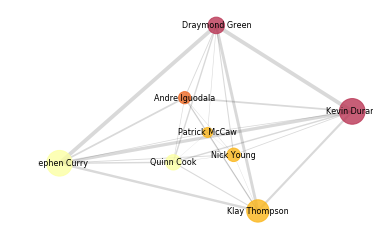

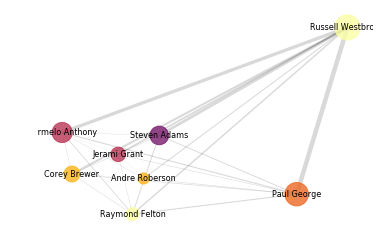

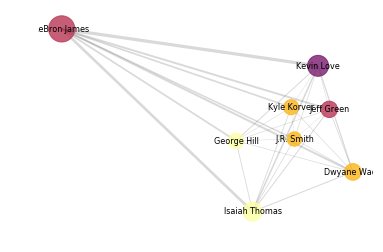

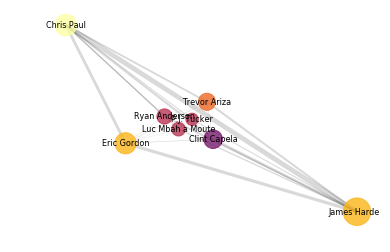

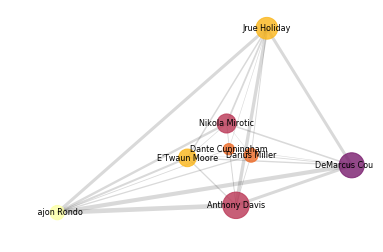

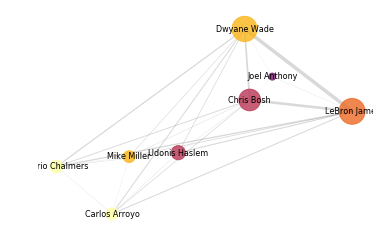

In [1208]:
visualize_graph_for_team_year(all_team_graphs['2018']['GSW'].to_undirected())
visualize_graph_for_team_year(all_team_graphs['2018']['OKC'])
visualize_graph_for_team_year(all_team_graphs['2018']['CLE'])
visualize_graph_for_team_year(all_team_graphs['2018']['HOU'])
visualize_graph_for_team_year(all_team_graphs['2018']['NOP'])
visualize_graph_for_team_year(all_team_graphs['2011']['MIA'])

In [1209]:
# weighted clustering - weighted tendency of nodes to connect to other nodes
weight_clust = {}
weighted_clustering_idx = {}
for curr_year in years_to_use[1:]:
    weight_clust[str(curr_year)] = {}
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    weighted_clustering_idx[str(curr_year)] = []
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team].to_undirected()
        A = get_weighted_clustering(G, extra_weighting_values="None")
        weight_clust[str(curr_year)][curr_team] = A
        # build a ratio of the top weighted value over the sum of the rest
        weighted_clustering_idx[str(curr_year)].append(np.mean(A))
    df_teams[str(curr_year)]['wclust_idx'] = weighted_clustering_idx[str(curr_year)]  

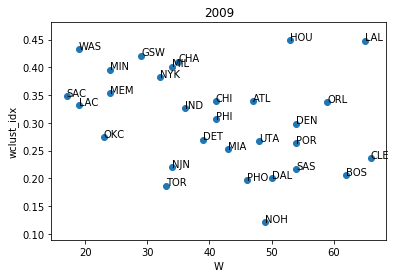

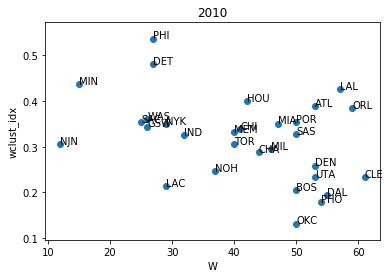

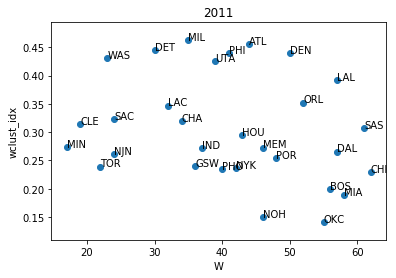

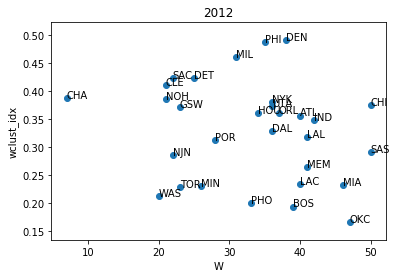

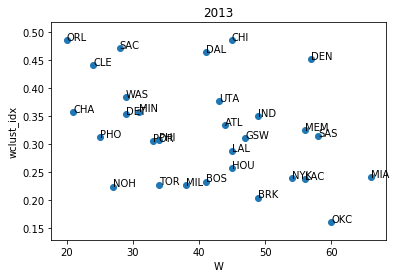

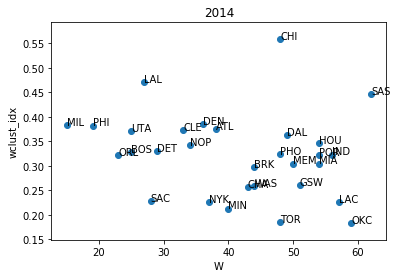

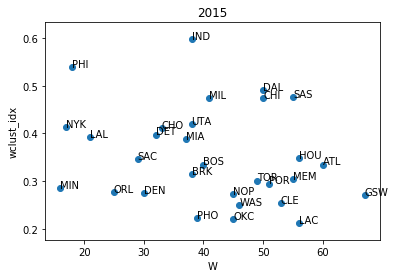

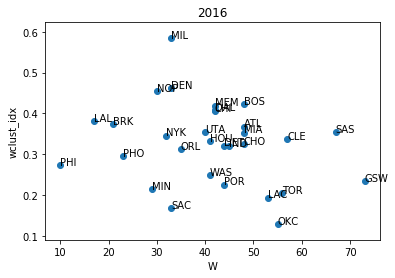

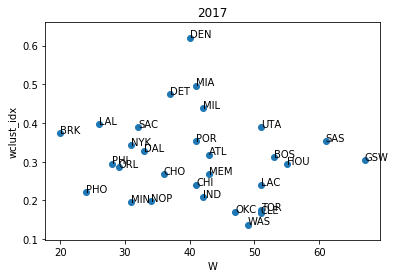

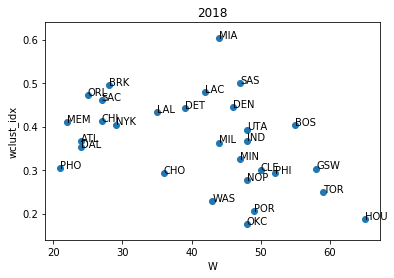

In [1210]:
for curr_year in years_to_use[1:]:
    plot_team_scatter(df_teams[str(curr_year)],'W','wclust_idx',str(curr_year))


In [1192]:
# shortest path length
G = all_team_graphs['2018']['GSW'].to_undirected()
A = dict(nx.shortest_path_length(G, weight='weight'))
print(A['Draymond Green'])

{'Draymond Green': 0, 'Patrick McCaw': 29.2, 'Nick Young': 39.42, 'Andre Iguodala': 42.4, 'Quinn Cook': 42.5, 'Klay Thompson': 57.2, 'Kevin Durant': 66.16, 'Stephen Curry': 66.16}


In [1211]:
# eigenvector, katz centrality, flow closeness - importance of single node
# avg shortest path length
eigcent_idx = {}
katzcent_idx = {}
flow_closeness = {}
for curr_year in years_to_use[1:]:
    eigcent[str(curr_year)] = {}
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    eigcent_idx[str(curr_year)] = []
    katzcent_idx[str(curr_year)] = []
    flow_closeness[str(curr_year)] = []
    splength[str(curr_year)] = []
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team].to_undirected()
        A = get_graph_metric(G, metric="eigenvector_centrality", extra_weighting_values="None")
        B = get_graph_metric(all_team_graphs[str(curr_year)][curr_team],
                             metric="katz_centrality", extra_weighting_values="None")
        C = get_graph_metric(G, metric="current_flow_closeness_centrality", extra_weighting_values="None") 
        # build a ratio of the top weighted value over the sum of the rest
        A.sort(reverse=True)
        eigcent_idx[str(curr_year)].append(A[0])
        katzcent_idx[str(curr_year)].append(np.max(B))
        flow_closeness[str(curr_year)].append(np.max(C)/np.sum(C))
    df_teams[str(curr_year)]['eigcent'] = eigcent_idx[str(curr_year)]  
    df_teams[str(curr_year)]['katzcent'] = katzcent_idx[str(curr_year)]  
    df_teams[str(curr_year)]['flow_closeness'] = flow_closeness[str(curr_year)] 

In [1167]:
all_team_graphs['2011']['MIA']

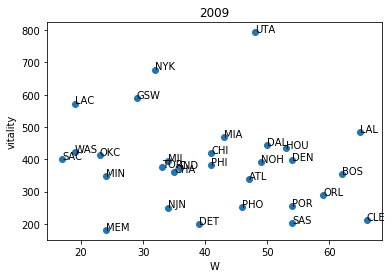

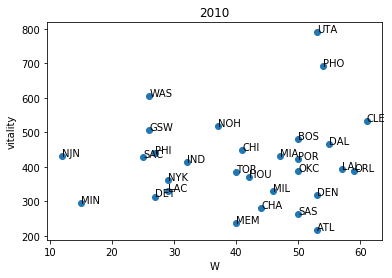

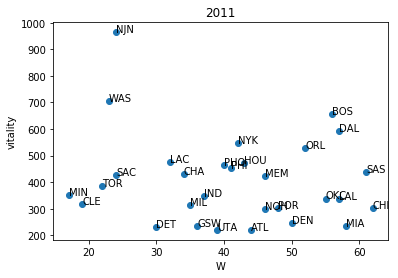

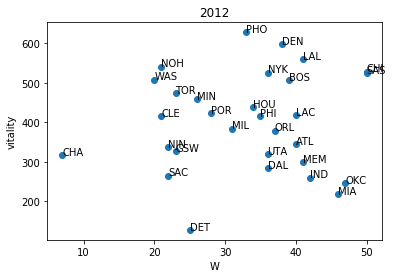

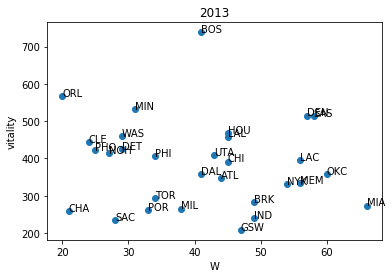

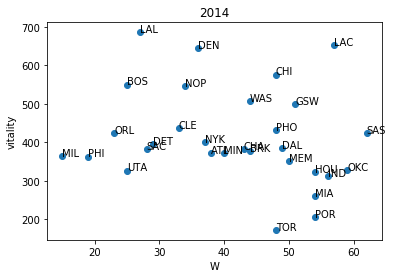

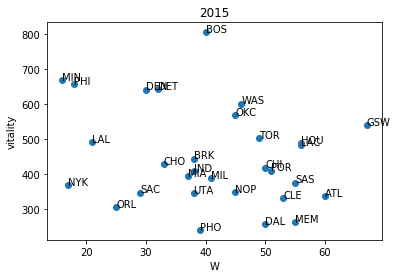

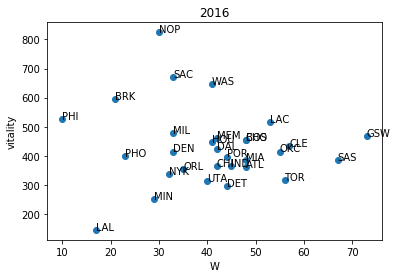

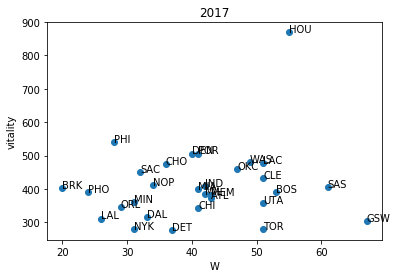

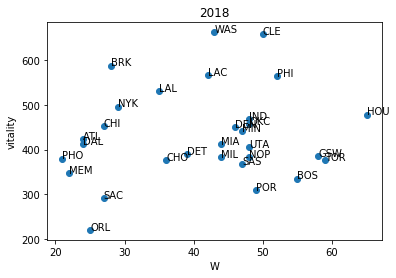

In [1214]:
for curr_year in years_to_use[1:]:
    plot_team_scatter(df_teams[str(curr_year)],'W','vitality',str(curr_year))

In [1213]:
# for Link analysis methods, shortest length method, and closeness vitality
pgrank = {}
splength = {}
dijlength = {}
vitality = {}
for curr_year in years_to_use[1:]:
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    pgrank[str(curr_year)] = []
    splength[str(curr_year)] = []
    dijlength[str(curr_year)] = []
    vitality[str(curr_year)] = []
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team]
        A = get_graph_metric(G, metric="pagerank")
        # lets take the pagerank of the best assist persion
        sorted_ast = sorted(nx.get_node_attributes(G,'ast').items(), key=lambda x: x[1])
        # this is the node index of the highest assist person so can save this value from A
        node_idx = list(G.nodes).index(sorted_ast[-1][0])
        pgrank[str(curr_year)].append(A[node_idx])
        # for length stuff
        B = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
        C = [B[i][j] for i in B for j in B[i]]
        dijlength[str(curr_year)].append(np.mean(C))
        D = nx.average_shortest_path_length(G, weight='weight')
        splength[str(curr_year)].append(D)
        # for vitality taking mean of the starting 5
        E = get_graph_metric(all_team_graphs[str(curr_year)][curr_team].to_undirected(),
                             metric="closeness_vitality")
        E.sort(reverse=True)
        vitality[str(curr_year)].append(np.max(E))
    df_teams[str(curr_year)]['pgrank'] = pgrank[str(curr_year)]  
    df_teams[str(curr_year)]['splength'] = splength[str(curr_year)] 
    df_teams[str(curr_year)]['dijlength'] = dijlength[str(curr_year)] 
    df_teams[str(curr_year)]['vitality'] = vitality[str(curr_year)]

In [977]:
G = all_team_graphs['2018']['CLE'].to_undirected()
A = nx.shot(G, weight= 'weight')
print(A)


{'LeBron James': 2342.1765832069436, 'J.R. Smith': 777.5287444100704, 'Kevin Love': 1219.1821207460594, 'George Hill': 1018.9214053059513, 'Isaiah Thomas': 1408.3606539908305, 'Jeff Green': 947.9883352928437, 'Dwyane Wade': 1202.8430059708812, 'Kyle Korver': 763.9601751837272}


In [1108]:
list(df_teams['2018'])

['3FG%',
 '3FG% ALLOW',
 '3FG%_shoot',
 '3FGA',
 '3FGA/G',
 '3FGM',
 '3FGM/G',
 'APG',
 'APG ALLOW',
 'AST',
 'AST/TO',
 'FG%',
 'FG% ALLOW',
 'FG%_shoot',
 'FGA',
 'FGA/G',
 'FGM',
 'FGM/G',
 'FT%',
 'FT% ALLOW',
 'FT%_shoot',
 'FTA',
 'FTA/G',
 'FTM',
 'FTM/G',
 'GP',
 'GP_ast',
 'GP_shoot',
 'PPG',
 'PPG ALLOW',
 'PPG DIFF',
 'PPG_shoot',
 'PPS',
 'PPS_shoot',
 'PTS IN PAINT',
 'PTS OFF TO',
 'PTS/POSS',
 'SEC CHANCE PTS',
 'TO',
 'TO%',
 'TPG',
 'TPG ALLOW',
 'TPG DIFF',
 'TS%',
 'Tm',
 'eFG%',
 'wclust_idx',
 'eigcent',
 'katzcent',
 'flow_closeness',
 'pgrank',
 'splength',
 'dijlength',
 'vitality']

In [1229]:
# lets divide up some of the basic team scoring and shooting stats 
# and ask what of the team metrics does the best at predicting them
from sklearn.ensemble import RandomForestClassifier
year_to_test = 2018
metrics_to_predict = ['W']
# here are the metrics from the graphs
graph_metrics = ['wclust_idx','eigcent','flow_closeness','pgrank','dijlength','splength','vitality']
# graph_metrics = ['splength','vitality']
# graph_metrics = ['APG','PPG','3FGA']
# lets divide these distributions into quartiles
quartiles_for_stats = {}
for curr_stat in metrics_to_predict:
    # this is the curr stat values for all years
    curr_stat_values = []
    for curr_year in years_to_use[1:]:
        year_stat = df_teams[str(curr_year)][curr_stat].tolist()
        curr_stat_values.extend(year_stat)
    curr_stat_values = np.asarray(curr_stat_values)
    # graph metrics
    curr_graph_metrics = []
    for curr_year in years_to_use[1:]:
        year_stat = df_teams[str(curr_year)][graph_metrics].as_matrix()
        curr_graph_metrics.extend(year_stat)
    curr_graph_metrics = np.asarray(curr_graph_metrics) 
    # quartiles for this stat
#     mid_quartiles = np.percentile(curr_stat_values, q=[25, 50, 75])
    mid_quartiles = np.percentile(curr_stat_values, q=[50])
    print(mid_quartiles)
    # build a vector where each value corresponds to which quartile
    team_quartile_vec = np.zeros(np.shape(curr_stat_values))
    for i in range(0,len(curr_stat_values)):
        if curr_stat_values[i] < mid_quartiles[0]:
            team_quartile_vec[i] = 0
        elif (curr_stat_values[i] >= mid_quartiles[0]) :
            team_quartile_vec[i] = 1
#         elif (curr_stat_values[i] >= mid_quartiles[0]) & (curr_stat_values[i] < mid_quartiles[1]):
#             team_quartile_vec[i] = 1
#         elif (curr_stat_values[i] >= mid_quartiles[1]) & (curr_stat_values[i] < mid_quartiles[2]):
#             team_quartile_vec[i] = 2
#         elif (curr_stat_values[i] >= mid_quartiles[2]):
#             team_quartile_vec[i] = 3
    rf = RandomForestClassifier(n_estimators=100,oob_score=True)
    rf.fit(curr_graph_metrics, team_quartile_vec)
    A = rf.oob_decision_function_
    print(rf.oob_score_)
    print(rf.feature_importances_)

[30. 41. 50.]
0.3233333333333333
[0.16543784 0.13254308 0.14454998 0.15634373 0.13321034 0.1355373
 0.13237773]


In [1121]:
# print(list(df_teams[str(curr_year)]))
A = df_teams[str(curr_year)][graph_metrics].as_matrix()
print(team_quartile_vec)
print(np.shape(curr_stat_values))


[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.]
(300,)


In [1391]:
from sklearn.manifold import TSNE
# clustering of team types
graph_metrics = ['wclust_idx','eigcent','flow_closeness','pgrank','dijlength','splength','vitality']
curr_graph_metrics = []
team_and_year = []
for curr_year in years_to_use[1:]:
    year_stat = df_teams[str(curr_year)][graph_metrics].as_matrix()
    curr_graph_metrics.extend(year_stat)
    # build variable that will save the teams and the year
    curr_teams = df_teams[str(curr_year)][['Tm']].as_matrix()
    team_plus_year = [[i[0], curr_year] for i in curr_teams]
    team_and_year.extend(team_plus_year)
curr_graph_metrics = np.asmatrix(curr_graph_metrics)
# lets normalize each column by the mean and the std
for curr_col in range(0,np.shape(curr_graph_metrics)[1]):
    curr_graph_metrics[:,curr_col] = normalize(curr_graph_metrics[:,curr_col])

# plt.plot(curr_graph_metrics)
# plt.legend(graph_metrics)
# plt.show()
# tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=1000)
# tsne_results = tsne.fit_transform(curr_graph_metrics)

(300, 2)


(300, 2)


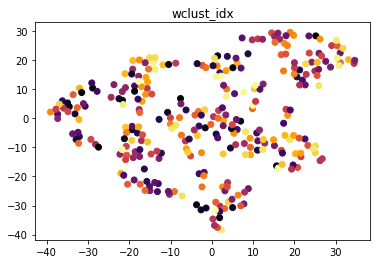

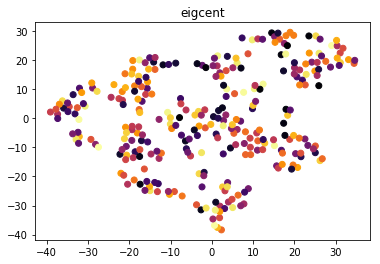

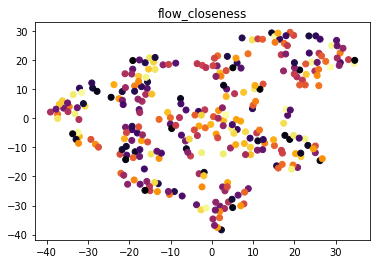

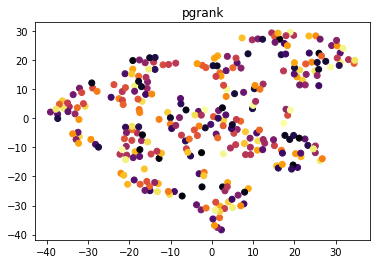

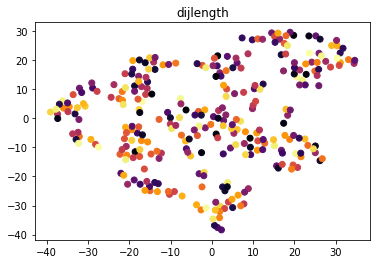

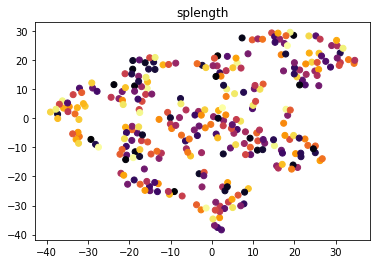

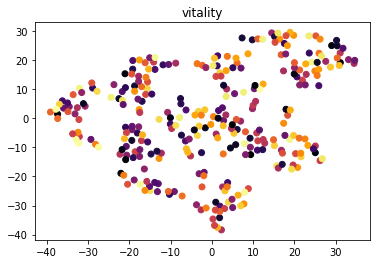

In [1342]:
print(np.shape(tsne_results))
cm = plt.get_cmap('inferno',np.shape(tsne_results)[0])
for j in range(0,len(graph_metrics)):
    vector = np.asarray(curr_graph_metrics[:,j])
    new_vector = [i[0] for i in vector]
    idx = np.argsort(new_vector)
    new_vector2 = [new_vector[i] for i in idx]
    cmap_colors = [cm.colors[i] for i in idx]
    plt.scatter(tsne_results[:,0],tsne_results[:,1],c=cmap_colors)
    plt.title(graph_metrics[j])
    plt.show()

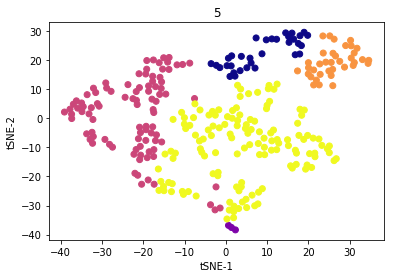

In [1562]:
from sklearn.cluster import AgglomerativeClustering
clusters_use = 5
model = AgglomerativeClustering(linkage='ward',
                                            n_clusters=clusters_use)
model.fit(curr_graph_metrics)
agg_clust_labels = model.labels_
# plt.plot(A)
# plt.show()
cm = plt.get_cmap('plasma_r',clusters_use)
cmap_colors = [cm.colors[i] for i in agg_clust_labels]
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=cmap_colors)
plt.title(str(clusters_use))
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.show()


['WAS', 2011]


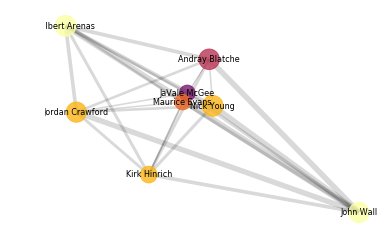

['NJN', 2011]


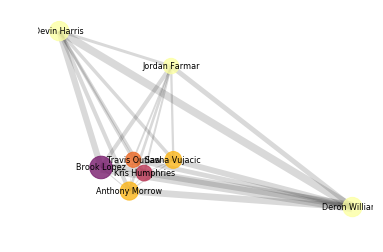

['ORL', 2013]


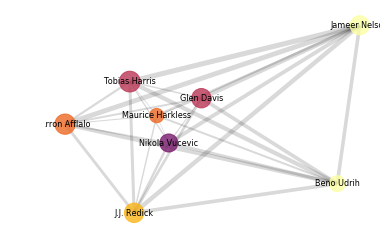

['LAL', 2014]


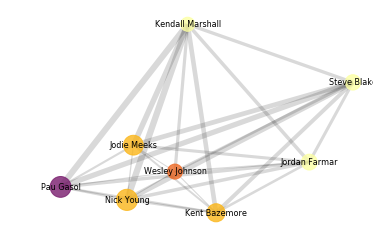

['BOS', 2015]


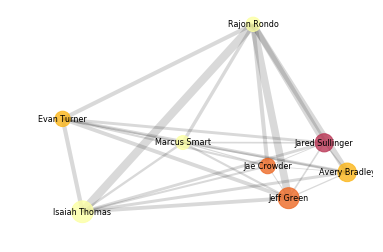

['PHI', 2015]


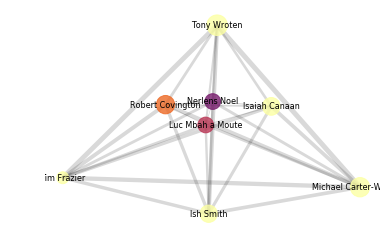

['NOP', 2016]


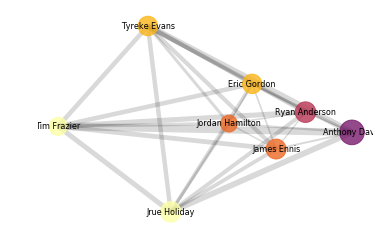

['HOU', 2017]


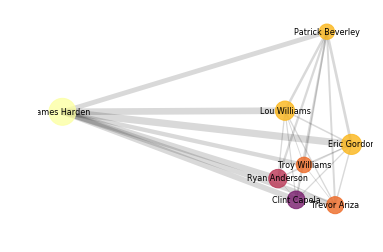

In [1555]:
# for each cluster lets plot all of the graphs for teams in that cluster
curr_cluster = 3
idx_of_that_cluster = np.where(agg_clust_labels == curr_cluster)
for i in idx_of_that_cluster[0]:
    curr_team_year = team_and_year[i]
    print(curr_team_year)
    visualize_graph_for_team_year(all_team_graphs[str(curr_team_year[1])][curr_team_year[0]])

In [1499]:
def plot_tsne_with_colors_sorted(tsne_result, vector, cmap_use):
    vector = np.asarray(vector)
#     new_vector = vector
    new_vector = [i[0] for i in vector]
#     plt.plot(new_vector)
#     plt.show()
    idx = np.argsort(new_vector)
    new_vector2 = [new_vector[i] for i in idx]
#     plt.plot(new_vector2)
#     plt.show()
    cmap_colors = [cmap_use[i] for i in idx]
    plt.scatter(tsne_results[idx,0],tsne_results[idx,1],c=cmap_use)
    plt.show()

['3FG%', '3FG% ALLOW', '3FG%_shoot', '3FGA', '3FGA/G', '3FGM', '3FGM/G', 'APG', 'APG ALLOW', 'AST', 'AST/TO', 'Away', 'Conf', 'Diff', 'Div', 'FG%', 'FG% ALLOW', 'FG%_shoot', 'FGA', 'FGA/G', 'FGM', 'FGM/G', 'FT%', 'FT% ALLOW', 'FT%_shoot', 'FTA', 'FTA/G', 'FTM', 'FTM/G', 'GB', 'GP', 'GP_ast', 'GP_shoot', 'Home', 'L', 'L10', 'PA', 'PF', 'PPG', 'PPG ALLOW', 'PPG DIFF', 'PPG_shoot', 'PPS', 'PPS_shoot', 'PTS IN PAINT', 'PTS OFF TO', 'PTS/POSS', 'Pct', 'SEC CHANCE PTS', 'Strk', 'TO', 'TO%', 'TPG', 'TPG ALLOW', 'TPG DIFF', 'TS%', 'W', 'eFG%', 'wclust_idx', 'eigcent', 'katzcent', 'flow_closeness', 'pgrank', 'splength', 'dijlength', 'vitality']


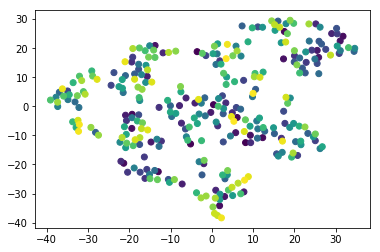

In [1563]:
all_metrics_list = list(df_teams['2018'])
all_metrics_list = [list(df_teams['2018'])[j] for j 
           in range(0,len(list(df_teams['2018']))) if isfloat(df_teams['2018'].iloc[0,j])]
print(all_metrics_list)
all_metrics = []
for curr_year in years_to_use[1:]:
    year_stat = df_teams[str(curr_year)][all_metrics_list].as_matrix()
    all_metrics.extend(year_stat)
all_metrics = np.asmatrix(all_metrics)
rm = plt.get_cmap('viridis',np.shape(all_metrics)[0])
plot_tsne_with_colors_sorted(tsne_results,all_metrics[:,all_metrics_list.index('W')], rm.colors)


(134, 1)
(36, 1)
(94, 1)
(3, 1)


Text(0.5,0,'Cluster')

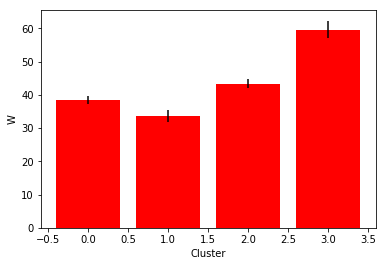

In [1564]:
# lets plot a bar plot looking at a certain category
curr_stat = 'W'
vector = all_metrics[:,all_metrics_list.index(curr_stat)]
vector = np.asarray(vector)
curr_bar = {}
curr_means = []
curr_SEM = []
for curr_clust in range(0,np.max(agg_clust_labels)):
    curr_bar[str(curr_clust)] = vector[agg_clust_labels == curr_clust]
    curr_means.append(np.mean(vector[agg_clust_labels == curr_clust]))
    curr_SEM.append(stats.sem(vector[agg_clust_labels == curr_clust]))
    print(np.shape(curr_bar[str(curr_clust)]))
fig, ax = plt.subplots()
rects1 = ax.bar(range(0,np.max(agg_clust_labels)), curr_means, color='r', yerr=curr_SEM)
plt.ylabel(curr_stat)
plt.xlabel('Cluster')

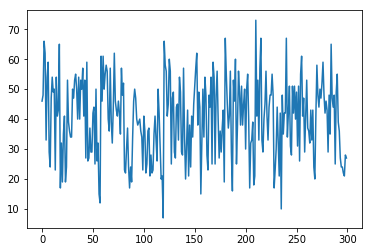

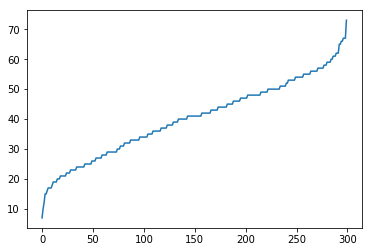

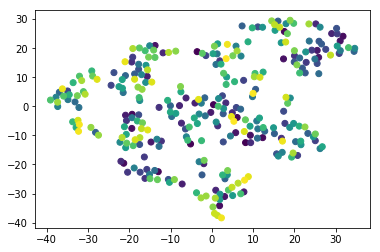

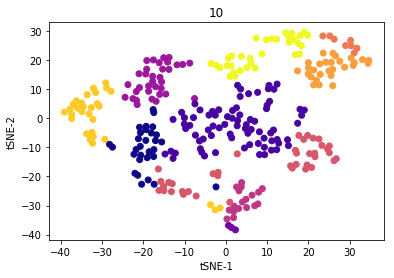

In [1493]:
# vector = list(agg_clust_labels)
vector = all_metrics[:,all_metrics_list.index('W')]
rm = plt.get_cmap('viridis',np.shape(all_metrics)[0])
cmap_use = rm.colors
vector = np.asarray(vector)
# new_vector = vector
new_vector = [i[0] for i in vector]
plt.plot(new_vector)
plt.show()
idx = np.argsort(new_vector)
new_vector2 = [new_vector[i] for i in idx]
plt.plot(new_vector2)
plt.show()
cmap_colors = [cmap_use[i] for i in idx]
plt.scatter(tsne_results[idx,0],tsne_results[idx,1],c=cmap_use)
plt.show()
cm = plt.get_cmap('plasma_r',clusters_use)
cmap_colors = [cm.colors[i] for i in agg_clust_labels]
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=cmap_colors)
plt.title(str(clusters_use))
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.show()